# Graphing the analysis of dart5.jpg and dart9.jpg

In [10]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import cv2
import math
import time
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import library as lib
pylab.rcParams['figure.figsize'] = (10,10)

In [7]:
## PROGRAMME STARTS

# Pre-annotated ground truths
ground = {0: np.array([[435,   6, 167, 194]]), 1: np.array([[198, 143, 191, 173]]), 2:
np.array([[ 97, 101,  98,  80]]), 3: np.array([[322, 150,  69,  69]]), 4:
np.array([[175, 104, 172, 180]]), 5: np.array([[426, 141,  92,  97]]), 6:
np.array([[210, 120,  63,  57]]), 7: np.array([[241, 174, 127, 131]]), 8:
np.array([[840, 225, 123, 104],[ 67, 255,  59,  84]]), 9:
np.array([[188,  36, 257, 253]]), 10: np.array([[ 78, 101, 121, 113],
[578, 127,  60,  91],[916, 149,  37,  69]]), 11:
np.array([[170, 107,  68,  50]]), 12: np.array([[153,  74,  65, 146]]), 13:
np.array([[269, 126, 135, 130]]), 14:
np.array([[117, 106, 134, 113],[981, 101, 128, 113]]), 15:
np.array([[151,  56, 136, 131]])}

# Setting the thresholds
edgethresh = 2.2
judgethresh = 0.5
# Setting the max and min radius of a detected circle in HT
minrad = 10
maxrad = 100
# Set the min proximity of any 2 HT circles`
proximity = 70

# whichdartimgs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
whichdartimgs = [5,9]

F1VJ = {}
F1VJHT = {}
PrecisionVJ = {}
PrecisionVJHT = {}
RecallVJ = {}
RecallVJHT = {}
start = time.time()
for i in whichdartimgs:

    # Loading a given image
    location = str("../images/dart") + str(i) + str(".jpg")
    imgcol = cv2.imread(location)
    img = cv2.cvtColor(imgcol, cv2.COLOR_BGR2GRAY)
    print ("dart" + str(i) + ".jpg loaded")
    if len(whichdartimgs) == 1:
        lib.imshow(imgcol, "Original Image.")


    # Finding the edges of the image above a threshold
    stime = time.time()
    grad, direc = lib.EdgeDetect (img, threshavg=edgethresh)
    print ("EdgeDetect runtime: " + str(time.time() - stime) )

    # Saving the edge image
    saveloc = (str("detected/dart" + str(i) + str("edge.jpg")))
    cv2.imwrite(saveloc,grad)
    print ("Edge image saved")
    if len(whichdartimgs) == 1:
        plt.title ("Edge image. Click to close")
        plt.imshow (grad, cmap='gray')
        plt.waitforbuttonpress()
        plt.close()

    #Running the Hough Transform for circles
    stime = time.time()
    Hxyr = lib.HTCircle(grad, direc, minrad, maxrad)
    etime = time.time()
    print("runtime: Hough Transform " + str(etime-stime))


    # Finding the Hough Space for the Hough Transform
    stime = time.time()
    Hspace = lib.HSpace(Hxyr)

    #Saving the Hough Space image
    saveloc = (str("detected/dart" + str(i) + str("HS.jpg")))
    cv2.imwrite(saveloc,Hspace)
    print ("Hough Space Runtime: " + str(time.time()-stime))
    print ("Hough image saved")
    if len(whichdartimgs) == 1:
        plt.title ("Hough Space. Click to close")
        plt.imshow(Hspace, cmap='gray')
        plt.waitforbuttonpress()
        plt.close()

    # Finding the rectangle that encloses the 3 most likely circles
    rect0, rect1, rect2 = lib.PlotRectangle(imgcol, Hxyr, Hspace, minrad, maxrad, prox=proximity)
    dart_HT = np.array([rect0,rect1,rect2])

    # Plotting the HT detection on the coloured image
    for (x,y,w,h) in dart_HT:
            cv2.rectangle(imgcol, (x,y), (x+w,y+h), (255,165,0), 3)

    # Saving the HT detected colour image
    saveloc = (str("detected/dart" + str(i) + str("HS_detect.jpg")))
    cv2.imwrite(saveloc,imgcol)
    print ("Hough transform image saved")
    if len(whichdartimgs) == 1:
        lib.imshow(imgcol, "Hough Transform detection.")

    #Reloading a fresh coloured image
    imgcol = cv2.imread(location)

    # Finding abd labeling the detected dartboards for Viola-Jones
    stime = time.time()
    classifier = cv2.CascadeClassifier('cascade.xml')
    dart_VJ = lib.ViolaJones(i, imgcol, classifier)
    for (x,y,w,h) in dart_VJ:
            cv2.rectangle(imgcol, (x,y), (x+w,y+h), (0,165,255), 3)

    # Saving VJ detected colour image
    saveloc = (str("detected/dart" + str(i) + str("VJ_detect.jpg")))
    cv2.imwrite(saveloc,imgcol)
    print ("Viola-Jones Runtime: " + str(time.time()-stime))
    print ("Viola-Jones image saved")
    if len(whichdartimgs) == 1:
        lib.imshow(imgcol, "Viola-Jones detection.")

    # Reload the coloured image
    imgcol = cv2.imread(location)

    # Combining Viola-Jones and Hough Transform by finding the overlapping classifications and plotting the corresponding VJ rectangle
    _, dart_VJHT = lib.Eval(dart_VJ,dart_HT, imgcol, thresh=judgethresh)
    # Note: the judgement array is unused

    # Saving the detection of combined VJ and HT
    saveloc = (str("detected/dart" + str(i) + str("VJHS_detect.jpg")))
    cv2.imwrite(saveloc,imgcol)
    print ("Joint HT & VJ image saved")
    if len(whichdartimgs) == 1:
        lib.imshow(imgcol, "Joint HT & VJ detection.")

    # Reload the coloured image
    imgcol = cv2.imread(location)
    judgementVJHT, _ =lib.Eval(ground[i], dart_VJHT, imgcol, thresh=judgethresh)
    imgcol = cv2.imread(location)
    judgementVJ, _ = lib.Eval(ground[i], dart_VJ,imgcol, thresh=judgethresh)
    detectionVJHT = lib.getinfo(judgementVJHT,dart_VJHT)
    detectionVJ = lib.getinfo(judgementVJ,dart_VJ)
    F1VJHT[i] = lib.f1score(detectionVJHT)
    F1VJ[i] = lib.f1score(detectionVJ)
    PrecisionVJ[i] = lib.ppv(detectionVJ)
    PrecisionVJHT[i] = lib.ppv(detectionVJHT)
    RecallVJ[i] = lib.tpr(detectionVJ)
    RecallVJHT[i] = lib.tpr(detectionVJHT)
    print ("dart" + str(i) + ".jpg done")
print ("Total runtime: " + str(time.time()-start))
print ("F1-VJ:")
print (F1VJ)
print ("F1-VJHT:")
print (F1VJHT)


dart5.jpg loaded
EdgeDetect runtime: 4.682901620864868
Edge image saved
Performing Hough Transform - Circles:
progress - 0%
progress - 3%
progress - 7%
progress - 10%
progress - 14%
progress - 17%
progress - 20%
progress - 24%
progress - 27%
progress - 31%
progress - 34%
progress - 37%
progress - 41%
progress - 44%
progress - 48%
progress - 51%
progress - 54%
progress - 58%
progress - 61%
progress - 65%
progress - 68%
progress - 71%
progress - 75%
progress - 78%
progress - 82%
progress - 85%
progress - 88%
progress - 92%
progress - 95%
progress - 99%
runtime: Hough Transform 165.45244693756104
Hough Space Runtime: 14.774035930633545
Hough image saved
Hough transform image saved
Viola-Jones Runtime: 0.03066420555114746
Viola-Jones image saved
Joint HT & VJ image saved
dart5.jpg done
dart9.jpg loaded
EdgeDetect runtime: 2.1593523025512695
Edge image saved
Performing Hough Transform - Circles:
progress - 0%
progress - 3%
progress - 7%
progress - 10%
progress - 14%
progress - 17%
progress 

### Comparing both images

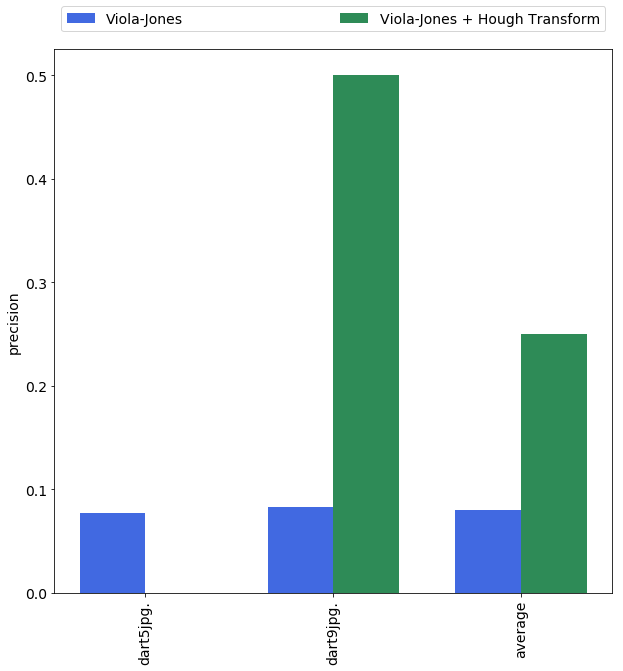

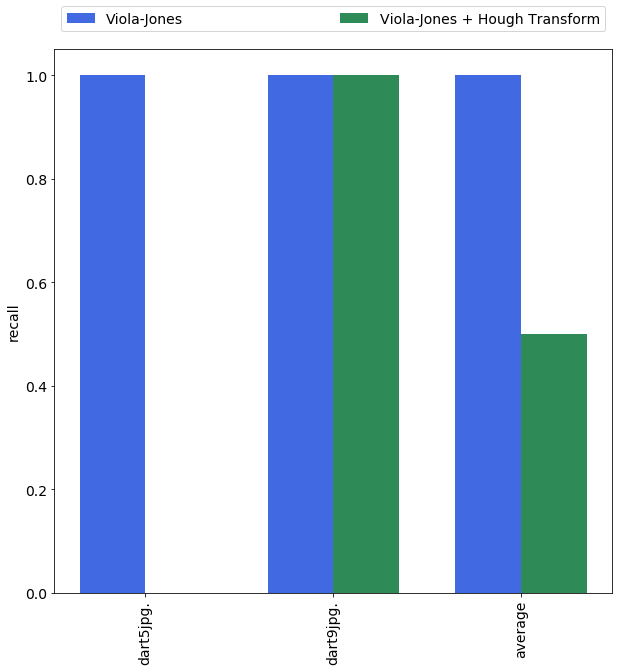

In [9]:
def f1bar(result1, result2, whichimgs, s):
    image_labels = []
    for i in whichimgs:
        if i == 20:
            each_image = 'average'
        else:
            each_image = 'dart'+str(i)+'jpg.'
        image_labels.append(each_image)

    indices = np.arange(len(image_labels))
    width = 0.35

    fig = plt.figure()
    ax = fig.add_subplot(111)
    bar1 = ax.bar(indices, result1, width, color = 'royalblue', label = 'Viola-Jones')
    bar2 = ax.bar(indices+width, result2, width, color = 'seagreen', label = 'Viola-Jones + Hough Transform')
    plt.xticks(indices+width/2, image_labels, rotation = 'vertical')
    plt.ylabel(s, fontsize=14)
    plt.legend(loc = 'lower left', bbox_to_anchor=(0,1.02,1,0.2), mode = 'expand', ncol = 2)
    plt.show()

    
    
avgVJ_P = sum(PrecisionVJ.values())/len(PrecisionVJ)
avgVJHT_P = sum(PrecisionVJHT.values())/len(PrecisionVJHT)
ResultVJ_P = [PrecisionVJ[5], PrecisionVJ[9], avgVJ_P]
ResultVJHT_P = [PrecisionVJHT[5], PrecisionVJHT[9], avgVJHT_P]
f1bar(ResultVJ_P, ResultVJHT_P, [5,9,20], "precision")

avgVJ_R = sum(RecallVJ.values())/len(RecallVJ)
avgVJHT_R = sum(RecallVJHT.values())/len(RecallVJHT)
ResultVJ_R = [RecallVJ[5], RecallVJ[9], avgVJ_R]
ResultVJHT_R = [RecallVJHT[5], RecallVJHT[9], avgVJHT_R]
f1bar(ResultVJ_R, ResultVJHT_R, [5,9,20],"recall")


### Visualising the evaluation method using the harmonic mean with threshold = 0.5

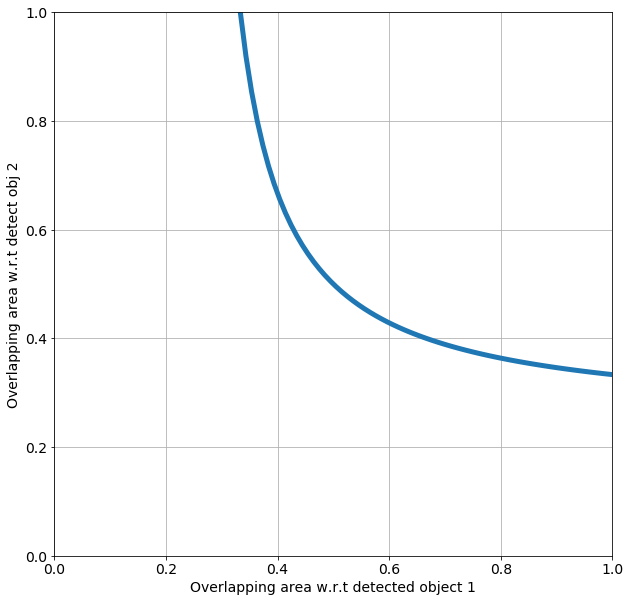

In [8]:
x = np.linspace(0,1,100)
def function(x):
    if x<0.25:
        return 100
    y = x/(4*x-1)
    return y

Y = []
for i in x:
    Y.append(function(i))

Y = np.array(Y)
plt.rcParams.update({'font.size': 14})
plt.xlim(0,1)
plt.xlabel("Overlapping area w.r.t detected object 1", fontsize = 14)
plt.ylabel("Overlapping area w.r.t detect obj 2", fontsize = 14)
plt.ylim(0,1)    
plt.grid(True)
plt.plot(x,Y, linewidth=5)
